# 0-1 Knapsack problem with deap

In this notebook, we implement many-objective [0-1 knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem#0-1_knapsack_problem) and solve it using [NSGA-II](https://web.njit.edu/~horacio/Math451H/download/2002-6-2-DEB-NSGA-II.pdf) and [NSGA-III](https://ieeexplore.ieee.org/abstract/document/6600851) genetic algorithms available in python library [``deap``](https://deap.readthedocs.io/en/master/examples/).

``deap`` documentation contains an implementation of the knapsack problem available [here](https://deap.readthedocs.io/en/master/examples/ga_knapsack.html). However, the proposed implementation considers 1 knapsack and aims to simultaneously maximize the profit and minimize the weight. This notebook implements a problem that maximizes profits for multiple knapsacks. The weights of knapsacks are not optimized but should satisfy specific constraints (see the problem formulation below). Additionally, we implement individual solutions using ``array``, while the implementation from `deap` is based on `set`.

## Problem formulation

We formulate the 0-1 knapsack problem in the same way as it is done in [(Zitzler and Eckart, 1999)](https://www.cse.unr.edu/~sushil/class/gas/papers/StrengthParetoEA.pdf).

Input:
1. $K$ - number of knapsacks
2. $I$ - number of items
3. $p_{k,i}$ - profit of item $i$ according to knapsack $k$
4. $w_{k,i}$ - weight of item $i$ according to knapsack $k$
5. $c_k$ - capasity of knapsack $k$

Objective: Find a vector $\vec{x} = (x_1, x_2, ..., x_I) \in \{0,1\}^{I}$ ($x_i = 1$ if item $i$ is selected and $x_i = 0$ otherwise) to maximize the following objective function given the contraints:


$$
\begin{aligned}
  max{(f_1(\vec{x}), f_2(\vec{x}), ..., f_K(\vec{x}))} \\
  \sum_{i}{w_{k,i}x_i} \leq c_k\\
  f_k(\vec{x}) := \sum_{i}{p_{k,i} x_{i}}\\
\end{aligned}
$$

The profits $p_{k,i}$ and weights $w_{k,i}$ are chosen as random uncorrelated integers in the interval $\left[10, 100\right]$. The knapsack capacities are set to half of the maximum weight regarding the corresponding knapsack:

\begin{equation}
    c_k = 0.5 \sum_{i} w_{k,i}
    \label{eq:choice-of-capacity}
\end{equation}


A particular vector $\vec{x}$ generated randomly or via a genetic procedure can
violate capacity restriction of a certain knapsack.
In this case, the greedy repair method is adopted. 
This method removes items from a particular solution until all capacity constraints are fulfilled.
The items are removed in the ascending order of maximum profit/weight ratio  $q_i$, which is given by the following equation

\begin{equation}
    q_i = \max_{k} \left\{ \frac{p_{k,i}}{w_{k,i}} \right\}
\end{equation}

In such a way, the items with lower profit per weight unit $q_j$ are removed first.
This procedure aims to fulfill all capacity constraints while reducing the overall profit as little as possible.

# Implementation

In this notebook, we do not discuss how to configure `deap` in detail, but rather present a working solution. For more details, check the documentation of `deap`, in particular [One Max Problem](https://deap.readthedocs.io/en/master/examples/ga_onemax.html) example and [Knapsack Problem: Inheriting from Set](https://deap.readthedocs.io/en/master/examples/ga_knapsack.html) example.

## Imports

In [163]:
import array
import random
import copy
import time
import subprocess
import os
import sys
#from emo import min_values
module_path = os.path.abspath(os.path.join('GA/code'))
if module_path not in sys.path:
    sys.path.append(module_path)

import math
import numpy as np
#import base, creator
from deap import base, creator
from deap.benchmarks.tools import hypervolume
import deap.tools as tools
from deap.tools.emo import *

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

## Intialization of 0-1 knapsack problem: 

1. Setting random weights and profits for the given number of items $n_i$ and knapsacks $n_k$;
2. Calculating $q_i$ for the greedy repair method.

In [164]:
# keys to access different attributes of a knapsack
weigh_key = 'W'
profit_key = 'P'
capacity_key = 'C'
q_key = 'Q'

def create_knapsack(n_i=7, n_k=5, low=10, high=100, random_seed=None):
    """
    n_i - number of items
    n_k - number of knapsacks
    low / high - boundaries for profits and weights
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    w_ki = np.random.randint(low=low, high=high + 1, size=(n_k, n_i))
    p_ki = np.random.randint(low=low, high=high + 1, size=(n_k, n_i))
    c_k = 0.5 * w_ki.sum(axis=1)
    q_i = np.argsort((p_ki / w_ki).max(axis=0))
    
    return {weigh_key: w_ki, profit_key: p_ki, capacity_key: c_k, q_key: q_i}

## Repair method

Implementation of the greedy repair method.

In [165]:
# calculate number of overweight knapsacks for a given individual
def get_num_of_overw_k(knapsack, ind):
    return sum((knapsack[weigh_key] * ind).sum(axis=1) > knapsack[capacity_key])

# repair individual
def repair_individual_list(ind, knapsack):
    num_of_overw_k = get_num_of_overw_k(knapsack, ind)
    if num_of_overw_k == 0:
        return
    for pos in knapsack[q_key]:
        if ind[pos] != 0:
            ind[pos] = 0
            num_of_overw_k = get_num_of_overw_k(knapsack, ind)
            if num_of_overw_k == 0:
                break
        pass
    pass

## Defining different functions

### Creation of an individual

An individual is represented as a list of size equal to the number of items $n_i$. Every individual is initialized randomly and after that is repaired using the greedy repair method.

In [166]:
def create_individual(n_i, knapsack):
    # randomly initialize vector x
    ind = np.random.randint(low=0, high=1 + 1, size=n_i)
    ind = ind.tolist()
    # repair individual if required
    num_of_overw_k = get_num_of_overw_k(knapsack, ind)
    if num_of_overw_k > 0:
        repair_individual_list(ind, knapsack)
    # returning a required type, 
    # see definition of creator.Individual below in `Genetic optimization` section
    return creator.Individual(ind)

### Calculating the value of objective function for the given individual

The value of the objective function is calculated according to the formulas provided above.

In [167]:
def eval_knapsack(knapsack, ind):
    res = (knapsack[profit_key] * ind).sum(axis=1)
    # deap required profits to be represented as tuples
    return tuple(res)

### Mating and mutation

The following mating and mutation functions are wrappers for an arbitrary mutation or mating strategy defined as a parameter ``func``. ``func`` can be a function from ``deap`` or a function defined by the user. After calling the function defined by `func`, the resulting individuals are repaired.

In [168]:
def mate_f(knapsack, func, ind1, ind2):
    ind1, ind2 = func(ind1, ind2)
    repair_individual_list(ind1, knapsack)
    repair_individual_list(ind2, knapsack)
    return ind1, ind2

def mutate_f(knapsack, func, indpb, ind):
    ind = func(ind, indpb)[0]
    repair_individual_list(ind, knapsack)
    return ind,

# mating with probability
def mate_f_prob(knapsack, func, indpb, ind1, ind2):
    ind1, ind2 = func(ind1, ind2, indpb=indpb)
    repair_individual_list(ind1, knapsack)
    repair_individual_list(ind2, knapsack)
    return ind1, ind2

### Visualization of solutions

The class below creates an animation to visualize the evolution of solutions and hypervolume with generations.

In [169]:
class UpdateDist:
    def __init__(self, ax, all_pop_arr, all_hypervolume_arr, legend_arr, n_obj, k_0=0, k_1=1,
                gen_mult=1):
        """
        all_pop_arr         - an array containing for every algorithm:
                                an array of populations for every generation
        all_hypervolume_arr - an array of hypervolume values for every generation
        legend_arr          - names of algorithms for generating legend
        n_obj               - number of objectives (number of knapsacks)
        k_0 & k_1           - 2 objectives, values of which will be displayed to show the evolution
                                of solutions
        gen_mult            - multiplier for displaying generation number if not every generation 
                                is displayed
        """
        
        self.gen_mult = gen_mult
        # setting the 2 chosen objectives
        self.k_0 = k_0
        self.k_1 = k_1
        # setting array of arrays of populations for every generation
        self.all_pop_arr = all_pop_arr
        
        # evolution of population is displayed on the first subplot
        self.ax_pop = ax[0]
        self.line_arr = []
        # for every algorithm initialize a scatter plot
        for i in range(0, len(all_pop_arr)):
            self.line_arr.append(self.ax_pop.scatter(x=[], y=[], s=10))
        # adding legend
        self.ax_pop.legend(legend_arr)
        # set plot parameters
        self.ax_pop.set_xlim(4000, 11000)
        self.ax_pop.set_ylim(4000, 13000)
        self.ax_pop.grid(True)
        self.ax_pop.title.set_text('Evolution of population')
        self.ax_pop.set_xlabel('Objective {}'.format(k_0))
        self.ax_pop.set_ylabel('Objective {}'.format(k_1))
        # textbox to display current generation
        self.gen_text = self.ax_pop.text(0.05, 0.9, '', transform=self.ax_pop.transAxes)
        # textbox to display size of the first front
        self.front_size_text = self.ax_pop.text(0.05, 0.8, '', transform=self.ax_pop.transAxes)
        
        # evolution of hypervolume is displayed on the second subplot
        self.ax_hypv = ax[1]
        # setting information about hypervolume for every algorithm
        self.hypervolume_arr_list = all_hypervolume_arr
        # itinialize a line for every algorithm
        self.line_hypv_arr = []
        for i in range(0, len(all_pop_arr)):
            self.line_hypv_arr.append(self.ax_hypv.plot([], [])[0])
        # setup plot parameters
        self.ax_hypv.legend(legend_arr)
        # x - number of generations
        self.ax_hypv.set_xlim(0, len(all_pop_arr[0]) * self.gen_mult)
        # set min and max values
        min_val = np.min(np.array(all_hypervolume_arr))
        max_val = np.max(np.array(all_hypervolume_arr))
        self.ax_hypv.set_ylim(min_val*0.9, max_val*1.1)
        self.ax_hypv.grid(True)
        self.ax_hypv.title.set_text('Hypervolume')
        self.ax_hypv.set_xlabel('Generation')
        
        
    def __call__(self, j):
        # initializing the display string
        first_front_str = '1-st front = '
        # loop through all algorithms
        for i in range(0, len(self.all_pop_arr)):
            # collecting values of 2 chosen objectives for the current generation
            k_0_arr = []
            k_1_arr = []
            pop = self.all_pop_arr[i][j]
            for el in pop:
                k_0_arr.append(el.fitness.values[self.k_0])
                k_1_arr.append(el.fitness.values[self.k_1])
                pass
            # displaying evolution of solutions as a scatter plot
            self.line_arr[i].set_offsets(np.array([k_0_arr, k_1_arr]).T)
            
            # displaying progress of hypervolume (previous values are also displayed)
            self.line_hypv_arr[i].set_data(
                np.arange(j+1) * self.gen_mult, 
                self.hypervolume_arr_list[i][:j+1]
            )
            # calculating size of the first front
            first_front_len_val = len(sortNondominated(pop, len(pop), first_front_only=True)[0])
            first_front_str += str(first_front_len_val) + "  /  "
            pass
        
        # displaying textboxes with the current generation number and front size
        self.gen_text.set_text('Generation {}'.format(j * self.gen_mult))
        self.front_size_text.set_text(first_front_str)
        
        return self.line_arr[0],  self.line_hypv_arr[0]

### Calculating number of dominated solutions

Function below are used to calculate number and fraction of solutions from the first front of $pop_1$ dominated by solutions from the first front of $pop_2$

In [170]:
def get_num_dominated(pop_1, pop_2):
    # compare just the first fronts
    front_1 = sortNondominated(pop_1, len(pop_1), first_front_only=True)[0]
    front_2 = sortNondominated(pop_2, len(pop_2), first_front_only=True)[0]
    return num_dominated(front_1, front_2)

def num_dominated(arr1, arr2):
    val_dominated = 0
    for el1 in arr1:
        for el2 in arr2:
            if sum(np.array(el2.fitness.values) > np.array(el1.fitness.values)) == len(el1.fitness.values):
                val_dominated += 1
                break
                pass
            pass
        pass
    return val_dominated, val_dominated / len(arr1), len(arr1)

### Average distance to diagonal

Diagonal in $n$-dimensional hyperspace is defined with the following equation: $x_1 = x_2 = \dots = x_n$.
In the case of $n=2$ and $x$ and $y$ being two axes, the conventional definition of the diagonal is the following: $y=x$.
Our optimization problem is symmetric by its nature. 
This means all objectives have the same scale.
In such a case, Euclidean distance between a solution and the diagonal shows how close or far the solution is to the extremes.
We will be using distance to diagonal as one of the evaluation criteria. 
The corresponding function is defined below.

Calculating the distance between a point $x_m$ and diagonal is equivalent to calculating the distance between $x_m$ and $x\_mean_m$, where all coordinates of $x\_mean_m$ equal to the mean value of coordinates of $x_m$.

In [171]:
def calc_avg_dist_diag(front):
    dist_diag = []
    for el in front:
        point = np.array(el.fitness.values)
        mean_val = point.mean() 
        dist_point = np.array([mean_val for i in range(0, len(point))])
        dist_diag.append(np.linalg.norm(point - dist_point))
        pass
    
    return np.mean(dist_diag)

## Genetic optimization

Below we define the genetic optimization algorithm consisting of the following steps:
1. Generate random population
2. Continue for the given number of generations:
    1. Select parents for mating
    2. Produce offsprings via mating and mutation
    3. Select the best individuals from the combined population (population of the previous generation + generated offsprings).
    
See the comments in the code for input parameters and details of implementation.

In [172]:
def compare_usual(ind1, ind2):
    dominate1 = True
    dominate2 = True
    for j in range(len(ind1.fitness.values)):
        if ind1.fitness.values[j]>ind2.fitness.values[j]:
            dominate2 = False
        if ind1.fitness.values[j]<ind2.fitness.values[j]:
            dominate1 = False
    if not dominate1 and not dominate2:
        return 0
    elif dominate1:
        return 1
    elif dominate2:
        return -1

def archive_dominate_ind(archive,ind):
    for i in archive:
        dflag = True
        flag = False
        for j in range(len(i.fitness.vector)):
            if ind.fitness.vector[j]>i.fitness.vector[j]:
                dflag = False
                break
            elif ind.fitness.vector[j]<i.fitness.vector[j]:
                flag = True
        if dflag and flag:
            return True
    return False

def ind_dominate_archive(archive,ind):
    counter = 0
    for i in reversed(range(len(archive))):
        dflag = False
        flag = True
        for j in range(len(archive[i].fitness.vector)):
            if ind.fitness.vector[j]>archive[i].fitness.vector[j]:
                dflag = True
            elif ind.fitness.vector[j]<archive[i].fitness.vector[j]:
                flag = False
                break
        if dflag and flag:
            counter += 1
            archive.pop(i)
    return counter

def archive_non_dominated1(archive, ind):
    for i in reversed(range(len(archive))):
        dflag = True
        for j in range(len(archive[i].fitness.vector)):
            if ind.fitness.vector[j]!=archive[i].fitness.vector[j]:
                dflag = False
                break
        if dflag:
            flag  = compare_usual(ind, archive[i])
            if flag == 1 or flag == 0:
                archive.pop(i)
                archive.append(ind)
                return True


def archive_update(archive, ind, epsilon):
    eps_box(ind, epsilon)
    if archive_dominate_ind(archive,ind):
        return archive
    elif ind_dominate_archive(archive, ind) > 0:
        return archive
    elif archive_non_dominated1(archive, ind):
        return True
    else:
        archive.append(ind)
        return archive




#Calculating B in epsilon dominance
def eps_box(ind,epsilon):
    ind.fitness.vector = []
    for i in range(len(ind.fitness.values)):
        ind.fitness.vector.append(math.ceil(float(ind.fitness.values[i])/epsilon))




In [173]:
def main_evolve(
    algo='NSGA-2',               
    knapsack_seed=0,             
    n_i=250,                     
    n_k=5,                       
    pop_size=200,    
    pop_seed=0,
    NGEN=10,                     
    knapsack=None,               
    is_unique_solutions=False,   
    num_iter_repair=0,           
    mating_algo='uniform',       
    sel_for_mating='random',      
    freq_cald_hypervolume=10, 
    is_save_all_gen=False,
    mating_prob=0.8,
    mutate_prob=0.01,
    p=None,
    freq_print_gen=None,
    epsilon = 0.01
):
    
    """
    algo='NSGA-2'               # sorting algorithm; possible values 
                                              [NSGA-2, NSGA-3, PO-count, PO-prob, PO-prob-repair]
    knapsack_seed=0             # random seed for initializing the knapsack
    n_i=250                     # number of items
    n_k=5                       # number of knapsacks
    pop_size=200                # population size
    pop_seed=0                  # random seed for generating the initial population; if None - random
                                                population is generated
    NGEN=10                     # number of generations
    knapsack=None               # already initialized knapsacks; 
                                               if knapsack is None, a new knapsack is initialized
                                               using `knapsack_seed`
    is_unique_solutions=False   # if True, make sure that there are no duplicates in population
    num_iter_repair=0           # number of repair iterations for PO-prob-repair
    mating_algo='uniform'       # if 'uniform' - mating function is `deap.tools.cxUniform`, 
                                               else - `deap.tools.cxOnePoint`
    sel_for_mating='random'     # strategy for selecting parents for mating
                                               possible values: ['random', 'best', 'tournament']
                                               the corresponding function are:
                                               [deap.tools.selRandom, deap.tools.selBest, 
                                                                   deap.tools.selTournament];
                                                Tournamement size is 2
    freq_cald_hypervolume=10    # frequency of calculating hypervolume in number of generation;
                                                hypervolume is kept constant inbetween.
    is_save_all_gen=False       # if True, save entire population for every generation
    mating_prob=0.8             # mating probability
    mutate_prob=0.01            # mutation probability
    p                           # parameter p of `deap.tools.emo.uniform_reference_points`
                                    for generation of uniformly distributed reference points for
                                    NSGA-III
    freq_print_gen=None         # frequency to print generation number; if None - not printed at all
    
    RETURN
    pop     - last population
    logbook - statistics about the evolution process
    pop_arr - array of all intermediate populations;
                if is_save_all_gen==False, pop_arr=None
    
    """
    
    # initialize new knapsack if required
    if knapsack is None:
        knapsack = create_knapsack(n_i=n_i, n_k=n_k, random_seed=knapsack_seed)
    else:
        print('Using existing knapsack')
    
    # optimization function is to be maximized; 
    # number of objectives is equal to the number of knapsacks
    creator.create("FitnessMax", base.Fitness, weights=(1.0,) * n_k)
    # every individual is a list
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    # toolbox initialization
    toolbox = base.Toolbox()
    # use create_individual function defined above to create individuals
    toolbox.register("individual", create_individual, n_i, knapsack)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # register evaluation function defined above
    toolbox.register("evaluate", eval_knapsack, knapsack)
    
    # set mating algorithm according to input parameters
    if mating_algo == 'uniform':
        toolbox.register("mate", mate_f_prob, knapsack, tools.cxUniform, 0.5)
    else:
        toolbox.register("mate", mate_f, knapsack, tools.cxOnePoint)
        
    # set mutation algorithm that will randomly change 0 for 1 and vice versa in the solution
    toolbox.register("mutate", mutate_f, knapsack, tools.mutFlipBit, mutate_prob)
    
    # set the strategy for selecting new population according to the chosen algorithm
    if algo == 'NSGA-2':
        toolbox.register("select", tools.selNSGA2, nd='standard',)
    elif algo == 'PO-count':
        toolbox.register("select", tools.selPO)
    elif algo == 'PO-prob' or algo == 'PO-prob-repair':
        toolbox.register("select", tools.selPO, nd='prob',)
    elif algo == 'WS':
        toolbox.register("select", tools.emo.selWS, nd='standard')
    elif algo == 'AR':
        toolbox.register("select", tools.emo.selAR, nd='standard')
    elif algo == 'Eps-MOEA':
        toolbox.register("select", tools.emo.selNSGA2, nd='standard')
    elif algo == 'NSGA-3':
        ref_points_nsga3 = uniform_reference_points(n_k, p)
        toolbox.register("select", tools.selNSGA3, ref_points=ref_points_nsga3, nd='standard',)
        pass

    # initializing logbook to track evolution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    stats.register("avg", np.mean, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    # the following information will be tracked:
    # gen - current generation
    # evals - number of evaluations of the objective function
    # avg / min / max - average / min / max value of objectives
    # hypervol - hypervolume
    # dist_diag - average distance to diagonal
    # time - time for sorting the population according to the toolbox.select algorithm set above
    # firts_front - size of the first front
    logbook.header = "gen", "evals", "avg", "min", "max", "hypervol", "dist_diag", \
                        "time", 'firts_front'

    # generate initial population
    if pop_seed is not None:
        print('Setting random seed to {}'.format(pop_seed))
        random.seed(pop_seed)
        np.random.seed(pop_seed)
    pop = toolbox.population(n=pop_size)
    # Evaluate the individuals
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # This is just to assign the distance to the individuals
    # no actual selection is done
    s = time.time()
    pop = toolbox.select(pop, len(pop))
    tot_time = time.time() - s
    # gether statistics for the generation 0
    front_1 = sortNondominated(pop, len(pop), first_front_only=True)[0]
    print('front 1:',len(front_1))
    if algo == 'Eps-MOEA':
        archive = copy.deepcopy(front_1)
        for i in range(len(archive)):
            eps_box(archive[i],epsilon)
    hypervol_val = calc_hypervolume_java(front_1)[1]
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), hypervol=hypervol_val, 
                   dist_diag=calc_avg_dist_diag(front_1),
                   time=tot_time, firts_front=len(front_1), **record)

    # save the current population, if required
    if is_save_all_gen:
        pop_arr = [copy.deepcopy(pop)]
    else:
        pop_arr = None
        
    # begin evolution
    for gen in range(1, NGEN+1):
        if freq_print_gen is not None and gen % freq_print_gen == 0:
            print(gen)
        if algo == 'PO-prob-repair' and gen == (NGEN-num_iter_repair):
            # repair last num_iter_repair generations
            toolbox.register("select", tools.selNSGA2, nd='standard',)
            pass

        
        # Vary the population
        if sel_for_mating == 'random':
            offspring = tools.selRandom(pop, len(pop))
        elif sel_for_mating == 'best':
            offspring = tools.selBest(pop, len(pop))
            pass
        elif sel_for_mating == 'tournament':
            offspring = tools.selTournament(pop, len(pop), tournsize=2)
            pass
        
        offspring = [toolbox.clone(ind) for ind in offspring]

        if is_unique_solutions:
            # make sure that every new solution is unique by storing storing all existing solutions
            # in a set of stings
            pop_str_set = set([str(pop[i]) for i in range(0, len(pop))])
            if algo == 'Eps-MOEA':
                arch_str_set = set([str(archive[i]) for i in range(0, len(archive))])

        #Case for Epsilon-dominance

        if algo == 'Eps-MOEA':
            pre_archive = []
            for ind1 in offspring[::2]:
                #Choosing individual from the archive
                #???
                ind2 = random.choice(copy.deepcopy(archive))

                if random.random() <= mating_prob:
                    toolbox.mate(ind1, ind2)
                toolbox.mutate(ind1)
                toolbox.mutate(ind2)
                if is_unique_solutions:
                    # mutate, until we get new idividual
                    while str(ind1) in pop_str_set:
                        toolbox.mutate(ind1)
                        pass
                    pop_str_set.add(str(ind1))
                if is_unique_solutions:
                    # mutate, until we get new idividual
                    while str(ind2) in arch_str_set:
                        toolbox.mutate(ind2)
                        pass
                    arch_str_set.add(str(ind2))
                del ind1.fitness.values, ind2.fitness.values
                pre_archive.append(ind1)
                pre_archive.append(ind2)
        else:
            for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
                if random.random() <= mating_prob:
                    toolbox.mate(ind1, ind2)
                toolbox.mutate(ind1)
                toolbox.mutate(ind2)
                if is_unique_solutions:
                    # mutate, until we get new idividual
                    while str(ind1) in pop_str_set:
                        toolbox.mutate(ind1)
                        pass
                    pop_str_set.add(str(ind1))
                if is_unique_solutions:
                    # mutate, until we get new idividual
                    while str(ind2) in pop_str_set:
                        toolbox.mutate(ind2)
                        pass
                    pop_str_set.add(str(ind2))
                # fitness values should be re-calculated
                del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        if algo == 'Eps-MOEA':
            invalid_ind_arch = [ind for ind in pre_archive if not ind.fitness.valid]
            fitnesses_arch = toolbox.map(toolbox.evaluate, invalid_ind_arch)
            for ind, fit in zip(invalid_ind_arch, fitnesses_arch):
                ind.fitness.values = fit
            for i in pre_archive:
                archive_update(archive,i,epsilon)

        # Select the population for the next generation
        s = time.time()
        if algo == 'Eps-MOEA':
            pop = toolbox.select(pop + pre_archive, pop_size)
        else:
            pop = toolbox.select(pop + offspring, pop_size)
        tot_time = time.time() - s

        record = stats.compile(pop)
        # size of the first front

        front_1 = sortNondominated(pop, len(pop), first_front_only=True)[0]
        # calculate hypervolume if required, otherwise save the previous result
        if gen % freq_cald_hypervolume == 0 or gen == NGEN:
            if algo == 'Eps-MOEA':
                hypervol_val = calc_hypervolume_java(archive)[1]
                print(hypervol_val)
                logbook.record(gen=gen, evals=len(invalid_ind_arch), hypervol=hypervol_val,
                       dist_diag=calc_avg_dist_diag(archive),
                       time=tot_time, firts_front=len(archive), **record)
            else:
                hypervol_val = calc_hypervolume_java(front_1)[1]
                print(hypervol_val)
                logbook.record(gen=gen, evals=len(invalid_ind), hypervol=hypervol_val,
                       dist_diag=calc_avg_dist_diag(front_1),
                       time=tot_time, firts_front=len(front_1), **record)
        # save current generation if required
        if is_save_all_gen:
            pop_arr.append(copy.deepcopy(pop))
            
        pass
    if algo == 'Eps-MOEA':
        return archive, logbook, pop_arr
    else:
        return pop, logbook, pop_arr

In [174]:
def calc_hypervolume_java(front, num_test=10000000):
    path = module_path +'/batch-analysis/'
    print (path)
    start = time.time()
    fitness_vals_arr = [list(front[i].fitness.values) for i in range(0, len(front))]
    with open('fitness_vals.txt', 'w') as f:
        for line in fitness_vals_arr:
            line_str = ''
            for el in line:
                line_str += str(el) + ' '
                pass
            f.write(line_str[:-1] + '\n')
            pass
        pass
    subprocess.run(["java", path + "Hypervolume", str(num_test)])
    with open(path + 'hypervolume.txt') as f:
        for line in f:
            num_hits = int(line)
            break
    max_vals = np.array(fitness_vals_arr).max(axis=0)
    return num_hits, max_vals.prod()*num_hits/num_test, time.time() - start

# Optimization

Setting input parameters

In [175]:
n_k = 2
n_i=250
pop_size = 250
ngen = 500

mating_algo = 'uniform'
# Calculation of hypervolume becomes longer for larger values of n_k. Increasing freq_cal_hypvol
# will speed up the evolution
freq_cal_hypvol = 50
freq_print_gen = 10
is_unique_solutions = True
is_save_all_gen = True
mating_prob = 1
mutate_prob = 0.01

# possible values : ['random', 'best', 'tournament']
parent_selection_method = 'random'


# setting a random seed for generating reproducible results
# and starting from the same population for different algorithms
seed_val = 20

Creating a knapsack

In [176]:
knapsack = create_knapsack(n_i=n_i, n_k=n_k, random_seed=0)

## NSGA-II

The process takes time, decrease the values of `freq_print_gen` to see it moving faster.

In [177]:
random.seed(seed_val)

start = time.time()
pop_nsga2, stats_nsga2, pop_arr_nsga2 = main_evolve(
    algo='NSGA-2',               
    knapsack_seed=None,             
    n_i=n_i,                     
    n_k=n_k,                       
    pop_size=pop_size,  
    pop_seed=seed_val,
    NGEN=ngen,                     
    knapsack=knapsack,               
    is_unique_solutions=is_unique_solutions,   
    num_iter_repair=None,           
    mating_algo=mating_algo,       
    sel_for_mating=parent_selection_method,      
    freq_cald_hypervolume=freq_cal_hypvol, 
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=freq_print_gen,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_nsga2

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

Using existing knapsack
Setting random seed to 20
front 1: 2
C:\Users\Света\GA\code/batch-analysis/
10


KeyboardInterrupt: 

## NSGA-III

### Reference points

NSGA-III requires user-provided reference points. 
We use `deap.tools.emo.uniform_reference_points` method to generate uniformly distributed reference points. 
This function takes 2 input parameters: `nobj` (number of objectives) and `p`.
Check the [original NSGA-III paper](https://ieeexplore.ieee.org/abstract/document/6600851) to learn how the uniformly distributed reference points can be generated. 

As suggested by the authors of NSGA-III, the number of reference points should be close to the value of population size.
Below we define the values of p that for a particular number of objectives generate approximately 250 reference points (for $pop\_size = 250$).

In [182]:
def get_p(n_k=2):
    if n_k == 2:
        return 250
    if n_k == 3:
        return 21
    if n_k == 4:
        return 9
    if n_k == 5:
        return 6
    if n_k == 6:
        return 5
    if n_k == 7 or n_k == 8:
        return 4
    if n_k > 8 and n_k < 14:
        return 3
    else:
        return 2
    pass

Check that the number of generated reference points is approximately equal to 250

In [183]:
for n_k_val in range(2, 26):
    p_val = get_p(n_k_val)
    num_ref_points = len(uniform_reference_points(n_k_val, p_val))
    print('n_k = {}, num_ref_points = {}'.format(n_k_val, num_ref_points))

n_k = 2, num_ref_points = 251
n_k = 3, num_ref_points = 253
n_k = 4, num_ref_points = 220
n_k = 5, num_ref_points = 210
n_k = 6, num_ref_points = 252
n_k = 7, num_ref_points = 210
n_k = 8, num_ref_points = 330
n_k = 9, num_ref_points = 165
n_k = 10, num_ref_points = 220
n_k = 11, num_ref_points = 286
n_k = 12, num_ref_points = 364
n_k = 13, num_ref_points = 455
n_k = 14, num_ref_points = 105
n_k = 15, num_ref_points = 120
n_k = 16, num_ref_points = 136
n_k = 17, num_ref_points = 153
n_k = 18, num_ref_points = 171
n_k = 19, num_ref_points = 190
n_k = 20, num_ref_points = 210
n_k = 21, num_ref_points = 231
n_k = 22, num_ref_points = 253
n_k = 23, num_ref_points = 276
n_k = 24, num_ref_points = 300
n_k = 25, num_ref_points = 325


Now run NSGA-III

p = 250
Using existing knapsack
Setting random seed to 20
front 1: 2
C:\Users\Света\GA\code/batch-analysis/
10
20
30
40
50
C:\Users\Света\GA\code/batch-analysis/
93005455.023
60
70
80
90
100
C:\Users\Света\GA\code/batch-analysis/
95541519.528
110
120
130
140
150
C:\Users\Света\GA\code/batch-analysis/
96886924.875
160
170
180
190
200
C:\Users\Света\GA\code/batch-analysis/
97309836.0
210
220
230
240
250
C:\Users\Света\GA\code/batch-analysis/
97675851.78
260
270
280
290
300
C:\Users\Света\GA\code/batch-analysis/
97908454.3905
310
320
330
340
350
C:\Users\Света\GA\code/batch-analysis/
98150977.1385
360
370
380
390
400
C:\Users\Света\GA\code/batch-analysis/
98391797.3025
410
420
430
440
450
C:\Users\Света\GA\code/batch-analysis/
98420835.708
460
470
480
490
500
C:\Users\Света\GA\code/batch-analysis/
98420835.708
Elapsed 252.42066025733948


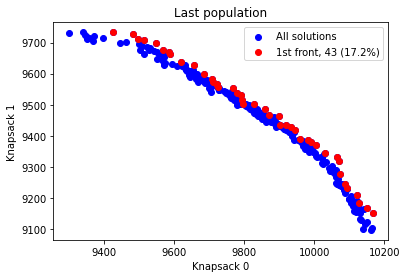

In [184]:
random.seed(seed_val)

p = get_p(n_k)
print('p = {}'.format(p))
start = time.time()
pop_nsga3, stats_nsga3, pop_arr_nsga3 = main_evolve(
    algo='NSGA-3',               
    knapsack_seed=None,             
    n_i=n_i,                     
    n_k=n_k,                       
    pop_size=pop_size,  
    pop_seed=seed_val,
    NGEN=ngen,                     
    knapsack=knapsack,               
    is_unique_solutions=is_unique_solutions,   
    num_iter_repair=None,           
    mating_algo=mating_algo,       
    sel_for_mating=parent_selection_method,      
    freq_cald_hypervolume=freq_cal_hypvol, 
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=p,
    freq_print_gen=freq_print_gen,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_nsga3

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## Eps-MOEA

Using existing knapsack
Setting random seed to 20
front 1: 2
C:\Users\Света\GA\code/batch-analysis/
10
20
30
40
50
C:\Users\Света\GA\code/batch-analysis/
92440868.4225
60
70
80
90
100
C:\Users\Света\GA\code/batch-analysis/
94901515.02
110
120
130
140
150
C:\Users\Света\GA\code/batch-analysis/
95932672.29
160
170
180
190
200
C:\Users\Света\GA\code/batch-analysis/
95343431.04
210
220
230
240
250
C:\Users\Света\GA\code/batch-analysis/
95653223.757
260
270
280
290
300
C:\Users\Света\GA\code/batch-analysis/
96043757.94
310
320
330
340
350
C:\Users\Света\GA\code/batch-analysis/
96774861.6315
360
370
380
390
400
C:\Users\Света\GA\code/batch-analysis/
97714844.136
410
420
430
440
450
C:\Users\Света\GA\code/batch-analysis/
97602517.35
460
470
480
490
500
C:\Users\Света\GA\code/batch-analysis/
97654341.7395
Elapsed 445.33646392822266


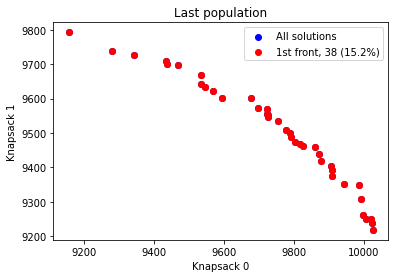

In [178]:
random.seed(seed_val)

start = time.time()
pop_po_count, stats_po_count, pop_arr_po_count = main_evolve(
    algo='Eps-MOEA',
    knapsack_seed=None,
    n_i=n_i,
    n_k=n_k,
    pop_size=pop_size,
    pop_seed=seed_val,
    NGEN=ngen,
    knapsack=knapsack,
    is_unique_solutions=is_unique_solutions,
    num_iter_repair=None,
    mating_algo=mating_algo,
    sel_for_mating=parent_selection_method,
    freq_cald_hypervolume=freq_cal_hypvol,
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=10,
    epsilon=0.01
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_count

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## WS-sorting

Using existing knapsack
Setting random seed to 20
front 1: 2
C:\Users\Света\GA\code/batch-analysis/
10
20
30
40
50
C:\Users\Света\GA\code/batch-analysis/
93275889.408
60
70
80
90
100
C:\Users\Света\GA\code/batch-analysis/
95874277.239
110
120
130
140
150
C:\Users\Света\GA\code/batch-analysis/
96170811.282
160
170
180
190
200
C:\Users\Света\GA\code/batch-analysis/
97492211.388
210
220
230
240
250
C:\Users\Света\GA\code/batch-analysis/
97646685.084
260
270
280
290
300
C:\Users\Света\GA\code/batch-analysis/
98620841.592
310
320
330
340
350
C:\Users\Света\GA\code/batch-analysis/
98620841.592
360
370
380
390
400
C:\Users\Света\GA\code/batch-analysis/
98912389.212
410
420
430
440
450
C:\Users\Света\GA\code/batch-analysis/
98912389.212
460
470
480
490
500
C:\Users\Света\GA\code/batch-analysis/
99090627.48
Elapsed 231.75629472732544


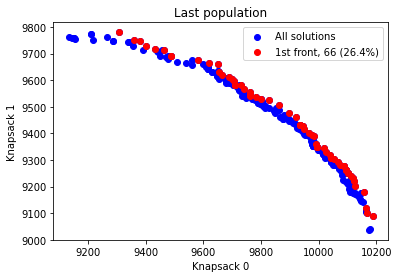

In [179]:
random.seed(seed_val)

start = time.time()
pop_po_count, stats_po_count, pop_arr_po_count = main_evolve(
    algo='WS',
    knapsack_seed=None,
    n_i=n_i,
    n_k=n_k,
    pop_size=pop_size,
    pop_seed=seed_val,
    NGEN=ngen,
    knapsack=knapsack,
    is_unique_solutions=is_unique_solutions,
    num_iter_repair=None,
    mating_algo=mating_algo,
    sel_for_mating=parent_selection_method,
    freq_cald_hypervolume=freq_cal_hypvol,
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=10,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_count

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## AR-sorting

In [ ]:
random.seed(seed_val)

start = time.time()
pop_po_count, stats_po_count, pop_arr_po_count = main_evolve(
    algo='AR',
    knapsack_seed=None,
    n_i=n_i,
    n_k=n_k,
    pop_size=pop_size,
    pop_seed=seed_val,
    NGEN=ngen,
    knapsack=knapsack,
    is_unique_solutions=is_unique_solutions,
    num_iter_repair=None,
    mating_algo=mating_algo,
    sel_for_mating=parent_selection_method,
    freq_cald_hypervolume=freq_cal_hypvol,
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=50,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_count

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## PO-count

Using existing knapsack
Setting random seed to 20
front 1: 2
C:\Users\Света\GA\code/batch-analysis/
10
20
30
40
50
C:\Users\Света\GA\code/batch-analysis/
92867782.41
60
70
80
90
100
C:\Users\Света\GA\code/batch-analysis/
95692644.7425
110
120
130
140
150
C:\Users\Света\GA\code/batch-analysis/
97493746.896
160
170
180
190
200
C:\Users\Света\GA\code/batch-analysis/
97628967.072
210
220
230
240
250
C:\Users\Света\GA\code/batch-analysis/
99051539.652
260
270
280
290
300
C:\Users\Света\GA\code/batch-analysis/
99335214.81
310
320
330
340
350
C:\Users\Света\GA\code/batch-analysis/
99335214.81
360
370
380
390
400
C:\Users\Света\GA\code/batch-analysis/
99335214.81
410
420
430
440
450
C:\Users\Света\GA\code/batch-analysis/
99423251.928
460
470
480
490
500
C:\Users\Света\GA\code/batch-analysis/
99511289.046
Elapsed 223.65194129943848


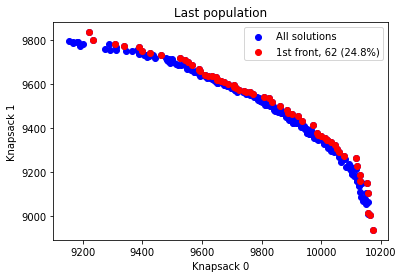

In [181]:
random.seed(seed_val)

start = time.time()
pop_po_count, stats_po_count, pop_arr_po_count = main_evolve(
    algo='PO-count',               
    knapsack_seed=None,             
    n_i=n_i,                     
    n_k=n_k,                       
    pop_size=pop_size,  
    pop_seed=seed_val,
    NGEN=500,
    knapsack=knapsack,               
    is_unique_solutions=is_unique_solutions,   
    num_iter_repair=None,           
    mating_algo=mating_algo,       
    sel_for_mating=parent_selection_method,      
    freq_cald_hypervolume=freq_cal_hypvol, 
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=freq_print_gen,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_count

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## PO-prob

In [ ]:
random.seed(seed_val)

start = time.time()
pop_po_prob, stats_po_prob, pop_arr_po_prob = main_evolve(
    algo='PO-prob',               
    knapsack_seed=None,             
    n_i=n_i,                     
    n_k=n_k,                       
    pop_size=pop_size,  
    pop_seed=seed_val,
    NGEN=ngen,                     
    knapsack=knapsack,               
    is_unique_solutions=is_unique_solutions,   
    num_iter_repair=None,           
    mating_algo=mating_algo,       
    sel_for_mating=parent_selection_method,      
    freq_cald_hypervolume=freq_cal_hypvol, 
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=freq_print_gen,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_prob

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()

## PO-prob-repair

In [ ]:
# use NSGA-II selection procedure for the last num_iter_repair generations
num_iter_repair = 150

random.seed(seed_val)

start = time.time()
pop_po_prob_repair, stats_po_prob_repair, pop_arr_po_prob_repair = main_evolve(
    algo='PO-prob-repair',               
    knapsack_seed=None,             
    n_i=n_i,                     
    n_k=n_k,                       
    pop_size=pop_size,  
    pop_seed=seed_val,
    NGEN=ngen,                     
    knapsack=knapsack,               
    is_unique_solutions=is_unique_solutions,   
    num_iter_repair=num_iter_repair,           
    mating_algo=mating_algo,       
    sel_for_mating=parent_selection_method,      
    freq_cald_hypervolume=freq_cal_hypvol, 
    is_save_all_gen=is_save_all_gen,
    mating_prob=mating_prob,
    mutate_prob=mutate_prob,
    p=None,
    freq_print_gen=freq_print_gen,
)
end = time.time()
print('Elapsed {}'.format(end-start))

pop = pop_po_prob_repair

# plot the values 1st and the 2d objectives for solutions from the last population and the first
# front of this population
pop_fitness = np.array([ind.fitness.values for ind in pop])
plt.scatter(pop_fitness[:, 0], pop_fitness[:, 1], c="b")
front_1 = sortNondominated(pop, len(pop), first_front_only=True)
front_1_vals = np.array([ind.fitness.values for ind in front_1[0]])
plt.scatter(front_1_vals[:, 0], front_1_vals[:, 1], c="r")
plt.axis("tight")
plt.title('Last population')
plt.xlabel('Knapsack 0')
plt.ylabel('Knapsack 1')
plt.legend(['All solutions', '1st front, {} ({}%)'
            .format(len(front_1_vals), len(front_1_vals) * 100. / pop_size)])
plt.show()


# Results

## Visualization of evolution

Let us now visualize the evolution of solutions together with the evolution of hypervolume

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
# display every `coef` generation 
coef = 10
all_hyp_arr = [
    #stats_nsga2.select('hypervol')[::coef],
    #stats_nsga3.select('hypervol')[::coef],
    #stats_po_count.select('hypervol')[::coef],
    stats_po_prob.select('hypervol')[::coef],
    stats_po_prob_repair.select('hypervol')[::coef],
]
all_pop_arr = [
    #pop_arr_nsga2[::coef], 
    #pop_arr_nsga3[::coef], 
    #pop_arr_po_count[::coef], 
    pop_arr_po_prob[::coef],
    pop_arr_po_prob_repair[::coef],
]
legend_arr= [
    #'NSGA-II', 
    #'NSGA-III',
    #'PO-count',  
    'PO-prob',
    'PO-prob-repair'
]

ud = UpdateDist(
    ax, 
    all_pop_arr=all_pop_arr, 
    all_hypervolume_arr=all_hyp_arr, 
    legend_arr=legend_arr, 
    n_obj=n_k, 
    gen_mult=coef,
    k_0=0,            # objectives to be visualized
    k_1=1,
)
anim = FuncAnimation(fig, 
                     ud, 
                     frames=int(len(pop_arr_nsga2)/coef),
                     interval=200, 
                     blit=True,
                    )
plt.close()
HTML(anim.to_html5_video())

## Fraction of dominated solutions

Check whose solutions are dominating

In [ ]:
print('For the last generation')
print('solutions of the first front of algorithm 1 dominated by the solutions of the first front of algorithm 2')
res = get_num_dominated(pop_arr_nsga2[-1], pop_arr_nsga3[-1])
print('NSGA-2   vs   NSGA-3   : dominated solutions = {}, {}%'.format(res[0], np.round(res[1]*100, 2)))
res = get_num_dominated(pop_arr_nsga3[-1], pop_arr_nsga2[-1])
print('NSGA-3   vs   NSGA-2   : dominated solutions = {}, {}%'.format(res[0], np.round(res[1]*100, 2)))

## Other metrics

Let us now plot the results for other metrics

In [ ]:
# legend for displaying
legend_arr= [
    'NSGA-II', 
    'NSGA-III',
    'PO-count',  
    'PO-prob',
    'PO-prob-repair'
]

Average distance to diagonal

In [ ]:
param = 'dist_diag'
title = 'Average distance to diagonal'

plt.plot(stats_nsga2.select(param))
plt.plot(stats_nsga3.select(param))
plt.plot(stats_po_count.select(param))
plt.plot(stats_po_prob.select(param))
plt.plot(stats_po_prob_repair.select(param))
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()

Time for selection of new generation in sec

In [ ]:
param = 'time'
title = 'Time for selection of the new population, sec'

plt.plot(stats_nsga2.select(param))
plt.plot(stats_nsga3.select(param))
plt.plot(stats_po_count.select(param))
plt.plot(stats_po_prob.select(param))
plt.plot(stats_po_prob_repair.select(param))
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()

Size of the first front

In [ ]:
param = 'firts_front'
title = 'Size of the first front'

plt.plot(stats_nsga2.select(param))
plt.plot(stats_nsga3.select(param))
plt.plot(stats_po_count.select(param))
plt.plot(stats_po_prob.select(param))
plt.plot(stats_po_prob_repair.select(param))
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()

Average value of a particual objective

In [ ]:
param = 'avg'
# change this value to display other objectives
objective_index = 0
title = 'Average for objective {}'.format(objective_index)

plt.plot(np.array(stats_nsga2.select(param)).T[objective_index])
plt.plot(np.array(stats_nsga3.select(param)).T[objective_index])
plt.plot(np.array(stats_po_count.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob_repair.select(param)).T[objective_index])
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()

Max value of a particual objective

In [ ]:
param = 'max'
# change this value to display other objectives
objective_index = 0
title = 'Max for objective {}'.format(objective_index)

plt.plot(np.array(stats_nsga2.select(param)).T[objective_index])
plt.plot(np.array(stats_nsga3.select(param)).T[objective_index])
plt.plot(np.array(stats_po_count.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob_repair.select(param)).T[objective_index])
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()

Min value of a particual objective

In [ ]:
param = 'min'
# change this value to display other objectives
objective_index = 0
title = 'Min for objective {}'.format(objective_index)

plt.plot(np.array(stats_nsga2.select(param)).T[objective_index])
plt.plot(np.array(stats_nsga3.select(param)).T[objective_index])
plt.plot(np.array(stats_po_count.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob.select(param)).T[objective_index])
plt.plot(np.array(stats_po_prob_repair.select(param)).T[objective_index])
plt.legend(legend_arr)
plt.xlabel('Generation')
plt.title(title)
plt.grid(True)
plt.show()